In [ ]:
!pip install -q datasets

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

hf_ds = load_dataset(
    "Max-Ploter/detection-moving-mnist-easy",split = "train"
    #split="train[:10000]"
)

print("HF len:", len(hf_ds))
print("Example keys:", hf_ds[0].keys())
#should show: ['video', 'labels', 'center_points', 'bboxes', 'bboxes_keypoints', 'bboxes_labels']


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train/data-00000-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00001-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00002-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00003-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00004-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00005-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00006-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00007-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00008-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00009-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00010-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00011-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

test/data-00000-of-00002.arrow:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

test/data-00001-of-00002.arrow:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

HF len: 24000
Example keys: dict_keys(['video', 'labels', 'center_points', 'bboxes', 'bboxes_keypoints', 'bboxes_labels'])


In [ ]:
class MovingMNISTHF(Dataset):
    def __init__(self, hf_dataset, num_digits=10):
        self.ds = hf_dataset
        self.num_digits = num_digits

    def __len__(self):
        return len(self.ds)

    def _process_video(self, video):
        video = np.array(video, dtype=np.float32)

        if video.ndim == 4:
            T, a, b, c = video.shape
            if c in (1, 3):
                video = video.mean(axis=-1)
            elif a in (1, 3):
                video = video.mean(axis=1)
            else:
                raise RuntimeError(f"Unexpected 4D video shape: {video.shape}")
        elif video.ndim == 3:
            if video.shape[0] in (1, 3) and video.shape[1] == video.shape[2]:
                video = video.mean(axis=0, keepdims=True)
        elif video.ndim == 2:
            video = video[None, :, :]
        else:
            raise RuntimeError(f"Unexpected video shape: {video.shape}")

        video /= 255.0
        video = video[:, None, :, :]
        video = video[::2]

        return video.astype(np.float32)

    def _process_labels(self, example):
        raw = example["labels"]
        labels_set = set()

        for frame_labels in raw:
            if frame_labels is None:
                continue
            for l in frame_labels:
                if isinstance(l, (int, np.integer)):
                    if 0 <= l < self.num_digits:
                        labels_set.add(int(l))

        labels = np.zeros(self.num_digits, dtype=np.float32)
        for l in labels_set:
            labels[l] = 1.0
        return labels

    def __getitem__(self, idx):
        example = self.ds[idx]

        video = self._process_video(example["video"])
        labels = self._process_labels(example)

        video = torch.from_numpy(video).float()
        labels = torch.from_numpy(labels).float()

        video = F.avg_pool2d(video, kernel_size=2)

        return video, labels


In [ ]:
# full_ds = MovingMNISTHF(hf_ds)

# train_size = int(0.8 * len(full_ds))
# val_size   = len(full_ds) - train_size

# train_ds, val_ds = random_split(
#     full_ds,
#     [train_size, val_size],
#     generator=torch.Generator().manual_seed(42),
# )

# train_loader = DataLoader(
#     train_ds,
#     batch_size=8,
#     shuffle=True,
#     num_workers=0,
# )

# val_loader = DataLoader(
#     val_ds,
#     batch_size=8,
#     shuffle=False,
#     num_workers=0,
# )

# #Sanity Check
# videos, labels = next(iter(train_loader))
# print("videos.shape:", videos.shape)
# print("labels.shape:", labels.shape)


In [ ]:
import torchvision.transforms.functional as TF
import torch

def hflip_video(video: torch.Tensor) -> torch.Tensor:
    frames = [TF.hflip(frame) for frame in video]
    return torch.stack(frames, dim=0)

def rotate_video(video: torch.Tensor, angle: float) -> torch.Tensor:
    frames = [TF.rotate(frame, angle=angle) for frame in video]
    return torch.stack(frames, dim=0)

def translate_video(video: torch.Tensor, tx: int, ty: int) -> torch.Tensor:
    frames = [
        TF.affine(
            frame,
            angle=0.0,
            translate=(tx, ty),
            scale=1.0,
            shear=[0.0, 0.0],
        )
        for frame in video
    ]
    return torch.stack(frames, dim=0)


In [ ]:
from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, base_dataset: Dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        video, labels = self.base_dataset[idx]
        video = self.transform(video)
        return video, labels


In [ ]:
from torch.utils.data import random_split, ConcatDataset

base_ds = MovingMNISTHF(hf_ds)

train_size = int(0.8 * len(base_ds))
# print(train_size)
val_size   = len(base_ds) - train_size

train_base, val_ds = random_split(
    base_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

sub_size = int(train_size*0.1)
train_flip, train_base = random_split(
    train_base,
    [sub_size, len(train_base)-sub_size],
    generator=torch.Generator().manual_seed(42),
)
# print(len(train_base))
# print(len(train_flip))

train_rot_90, train_base = random_split(
    train_base,
    [sub_size, len(train_base)-sub_size],
    generator=torch.Generator().manual_seed(42),
)

train_rot_180, train_base = random_split(
    train_base,
    [sub_size, len(train_base)-sub_size],
    generator=torch.Generator().manual_seed(42),
)

train_rot_270, train_base = random_split(
    train_base,
    [sub_size, len(train_base)-sub_size],
    generator=torch.Generator().manual_seed(42),
)

# print(len(train_base))
# print(len(train_rot))

train_trans, train_base = random_split(
    train_base,
    [sub_size, len(train_base)-sub_size],
    generator=torch.Generator().manual_seed(42),
)

# print(len(train_base))
# print(len(train_trans))

train_flip = TransformedDataset(
    train_flip,
    transform=hflip_video,
)

train_rot_90 = TransformedDataset(
    train_rot_90,
    transform=lambda v: rotate_video(v, angle=90),
)

train_rot_180 = TransformedDataset(
    train_rot_180,
    transform=lambda v: rotate_video(v, angle=90),
)

train_rot_270 = TransformedDataset(
    train_rot_270,
    transform=lambda v: rotate_video(v, angle=90),
)

train_trans = TransformedDataset(
    train_trans,
    transform=lambda v: translate_video(v, tx=5, ty=5),
)

train_ds = ConcatDataset([train_base, train_flip, train_rot_90, train_rot_180, train_rot_270, train_trans])
# print(len(train_ds))
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)

# val_loader = DataLoader(
#     val_ds,
#     batch_size=8,
#     shuffle=False,
#     num_workers=0,
# )

#Sanity Check
videos, labels = next(iter(train_loader))
print("videos.shape:", videos.shape)
print("labels.shape:", labels.shape)


videos.shape: torch.Size([8, 10, 1, 64, 64])
labels.shape: torch.Size([8, 10])


In [ ]:
from torch.utils.data import ConcatDataset

# orig_val_loader = val_loader
print(len(val_ds))
sub_size = int(val_size*0.1)

hflip_val_ds, val_ds = random_split(
    val_ds,
    [sub_size, len(val_ds)-sub_size],
    generator=torch.Generator().manual_seed(42),
)
rot90_val_ds, val_ds= random_split(
    val_ds,
    [sub_size, len(val_ds)-sub_size],
    generator=torch.Generator().manual_seed(42),
)
rot180_val_ds, val_ds = random_split(
    val_ds,
    [sub_size, len(val_ds)-sub_size],
    generator=torch.Generator().manual_seed(42),
)
rot270_val_ds, val_ds = random_split(
    val_ds,
    [sub_size, len(val_ds)-sub_size],
    generator=torch.Generator().manual_seed(42),
)
trans_val_ds, val_ds, = random_split(
    val_ds,
    [sub_size, len(val_ds)-sub_size],
    generator=torch.Generator().manual_seed(42),
)


hflip_val_ds = TransformedDataset(hflip_val_ds, transform=hflip_video)
# hflip_val_loader = DataLoader(
#     hflip_val_ds, batch_size=8, shuffle=False, num_workers=0
# )

rot90_val_ds = TransformedDataset(
    rot90_val_ds,
    transform=lambda v: rotate_video(v, angle=90)
)
# rot90_val_loader = DataLoader(
#     rot90_val_ds, batch_size=8, shuffle=False, num_workers=0
# )

rot180_val_ds = TransformedDataset(
    rot180_val_ds,
    transform=lambda v: rotate_video(v, angle=180)
)
# rot180_val_loader = DataLoader(
#     rot180_val_ds, batch_size=8, shuffle=False, num_workers=0
# )

rot270_val_ds = TransformedDataset(
    rot270_val_ds,
    transform=lambda v: rotate_video(v, angle=270)
)
# rot270_val_loader = DataLoader(
#     rot270_val_ds, batch_size=8, shuffle=False, num_workers=0
# )

trans_val_ds = TransformedDataset(
    trans_val_ds,
    transform=lambda v: translate_video(v, tx=5, ty=5)
)
# trans_val_loader = DataLoader(
#     trans_val_ds, batch_size=8, shuffle=False, num_workers=0
# )

val_2_ds = ConcatDataset([val_ds, hflip_val_ds, rot90_val_ds, rot180_val_ds, rot270_val_ds, trans_val_ds])
print(len(val_2_ds))

val_2_loader = DataLoader(
    val_2_ds, batch_size=8, shuffle=False, num_workers=0
)

4800
4800


In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, cnn_feature_dim=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Dropout2d(0.3),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, cnn_feature_dim)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.relu(x)

In [ ]:
class CNNRNNClassifier(nn.Module):
    def __init__(
        self,
        num_classes=10,
        cnn_feature_dim=128,
        rnn_hidden_dim=128,
        rnn_num_layers=1,
        bidirectional=True,
        rnn_dropout=0.3,
    ):
        super().__init__()
        self.cnn = CNNEncoder(cnn_feature_dim=cnn_feature_dim)
        self.num_directions = 2 if bidirectional else 1

        self.rnn = nn.GRU(
            input_size=cnn_feature_dim,
            hidden_size=rnn_hidden_dim,
            num_layers=rnn_num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=rnn_dropout if rnn_num_layers > 1 else 0.0,
        )

        self.out_dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.num_directions * rnn_hidden_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        frame_feats = self.cnn(x)
        Fdim = frame_feats.size(-1)
        frame_feats = frame_feats.view(B, T, Fdim)

        out, _ = self.rnn(frame_feats)
        pooled = out.mean(dim=1)

        logits = self.fc(pooled)
        return logits


In [ ]:
model = CNNRNNClassifier(num_classes=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,patience=3)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    total_batches = 0

    for batch in loader:
        videos, labels = batch

        videos = videos.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        logits = model(videos)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            batch_acc = (preds == labels).float().mean().item()

        epoch_loss += loss.item()
        epoch_acc += batch_acc
        total_batches += 1

    return epoch_loss / total_batches, epoch_acc / total_batches


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    epoch_acc = 0.0
    total_batches = 0

    for batch in loader:
        videos, labels = batch

        videos = videos.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)

        logits = model(videos)
        loss = criterion(logits, labels)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        batch_acc = (preds == labels).float().mean().item()

        epoch_loss += loss.item()
        epoch_acc += batch_acc
        total_batches += 1

    return epoch_loss / total_batches, epoch_acc / total_batches


In [ ]:
num_epochs = 10
history = {
    "train_loss": [],
    "train_acc": [],
    # "val_loss": [],
    # "val_acc": [],
    "val_2_loss": [],
    "val_2_acc": [],
}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    # val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_2_loss, val_2_acc = evaluate(model, val_2_loader, criterion, device)
    # scheduler.step(val_loss)
    scheduler.step(val_2_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    # history["val_loss"].append(val_loss)
    # history["val_acc"].append(val_acc)
    history["val_2_loss"].append(val_2_loss)
    history["val_2_acc"].append(val_2_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_2_loss:.4f} | Val Acc: {val_2_acc:.4f}"
    )


Epoch 01 | Train Loss: 0.6190 | Train Acc: 0.6462 | Val Loss: 0.6129 | Val Acc: 0.6557
Epoch 02 | Train Loss: 0.6152 | Train Acc: 0.6499 | Val Loss: 0.6200 | Val Acc: 0.6398
Epoch 03 | Train Loss: 0.6143 | Train Acc: 0.6517 | Val Loss: 0.6108 | Val Acc: 0.6557
Epoch 04 | Train Loss: 0.6137 | Train Acc: 0.6524 | Val Loss: 0.6124 | Val Acc: 0.6527
Epoch 05 | Train Loss: 0.6135 | Train Acc: 0.6533 | Val Loss: 0.6108 | Val Acc: 0.6564
Epoch 06 | Train Loss: 0.6132 | Train Acc: 0.6537 | Val Loss: 0.6117 | Val Acc: 0.6535
Epoch 07 | Train Loss: 0.6131 | Train Acc: 0.6536 | Val Loss: 0.6109 | Val Acc: 0.6563
Epoch 08 | Train Loss: 0.6122 | Train Acc: 0.6545 | Val Loss: 0.6098 | Val Acc: 0.6569
Epoch 09 | Train Loss: 0.6121 | Train Acc: 0.6542 | Val Loss: 0.6101 | Val Acc: 0.6565
Epoch 10 | Train Loss: 0.6120 | Train Acc: 0.6549 | Val Loss: 0.6101 | Val Acc: 0.6574


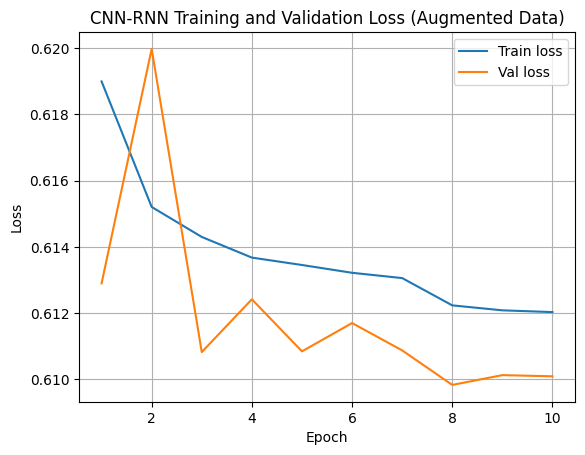

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# ---- Loss plot ----
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train loss")
# plt.plot(epochs, history["val_loss"], label="Val loss")
plt.plot(epochs, history["val_2_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN-RNN Training and Validation Loss (Augmented Data)")
plt.legend()
plt.grid(True)
plt.show()


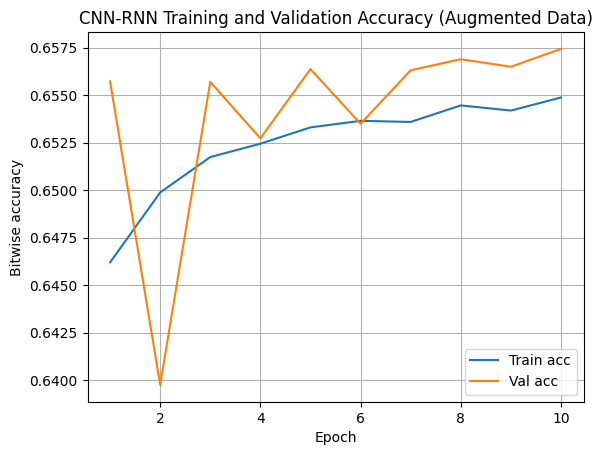

In [ ]:
# ---- Accuracy plot ----
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train acc")
# plt.plot(epochs, history["val_acc"], label="Val acc")
plt.plot(epochs, history["val_2_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Bitwise accuracy")
plt.title("CNN-RNN Training and Validation Accuracy (Augmented Data)")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
# print("Original val:")
# orig_loss, orig_acc = evaluate(model, orig_val_loader, criterion, device)
# print(f"  Loss: {orig_loss:.4f}, Acc: {orig_acc:.4f}")

# print("Horizontally flipped val:")
# hflip_loss, hflip_acc = evaluate(model, hflip_val_loader, criterion, device)
# print(f"  Loss: {hflip_loss:.4f}, Acc: {hflip_acc:.4f}")

# print("Rotated +90° val:")
# rot90_loss, rot90_acc = evaluate(model, rot90_val_loader, criterion, device)
# print(f"  Loss: {rot90_loss:.4f}, Acc: {rot90_acc:.4f}")

# print("Rotated +180° val:")
# rot180_loss, rot180_acc = evaluate(model, rot180_val_loader, criterion, device)
# print(f"  Loss: {rot180_loss:.4f}, Acc: {rot180_acc:.4f}")

# print("Rotated +270° val:")
# rot270_loss, rot270_acc = evaluate(model, rot270_val_loader, criterion, device)
# print(f"  Loss: {rot270_loss:.4f}, Acc: {rot270_acc:.4f}")

# print("Translated (5,5) val:")
# trans_loss, trans_acc = evaluate(model, trans_val_loader, criterion, device)
# print(f"  Loss: {trans_loss:.4f}, Acc: {trans_acc:.4f}")


In [ ]:
# import matplotlib.pyplot as plt

# transforms = [
#     "Original",
#     "H Flip",
#     "Rot +90°",
#     "Rot +180°",
#     "Rot +270°",
#     "Trans (5,5)"
# ]

In [ ]:
# losses = [
#     orig_loss,
#     hflip_loss,
#     rot90_loss,
#     rot180_loss,
#     rot270_loss,
#     trans_loss,
# ]

# plt.figure(figsize=(8, 4))
# plt.bar(transforms, losses)
# plt.ylabel("Loss")
# plt.title("Validation Loss across Transformations")
# plt.xticks(rotation=30, ha="right")
# plt.tight_layout()
# plt.show()

In [ ]:
# accuracies = [
#     orig_acc,
#     hflip_acc,
#     rot90_acc,
#     rot180_acc,
#     rot270_acc,
#     trans_acc,
# ]

# acc_percent = [a * 100 for a in accuracies]

# plt.figure(figsize=(8, 4))
# plt.bar(transforms, acc_percent)
# plt.ylabel("Accuracy (%)")
# plt.title("Validation Accuracy across Transformations")
# plt.xticks(rotation=30, ha="right")
# plt.tight_layout()
# plt.show()